In [1]:
import pandas as pd
from src.data import DataLoader
from src.evaluate import evaluate
from src.preprocessing import PreProcessClass
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%reload_ext autoreload
%autoreload 2

# Load Raw Datasets

In [2]:
loader = DataLoader("datasets2025")
consumer_it, temp_it, pred_it = loader.load_data(country="IT")
consumer_es, temp_es, pred_it = loader.load_data(country="ES")

## Preprocessing

In [3]:
loader_it = PreProcessClass(consumer_it, temp_it)
consumers_it_df = []
consumers_it_df_skipped = []
for cust in tqdm(consumer_it.columns, desc="Preprocessing IT consumers"):

    tmp_df = loader_it.preprocess_nonan([cust])
    if tmp_df.isna().sum().sum() > 0:
        consumers_it_df_skipped.append(cust)
        continue
    tmp_df["id"] = cust
    consumers_it_df.append(tmp_df)
print(f"Consumers IT: {len(consumers_it_df)}")
consumers_it_df = pd.concat(consumers_it_df)

loader_es = PreProcessClass(consumer_es, temp_es)
consumers_es_df = []
consumers_es_df_skipped = []

for cust in tqdm(consumer_es.columns, desc="Processing ES consumers"):

    tmp_df = loader_es.preprocess_nonan([cust])
    if tmp_df.isna().sum().sum() > 0:
        consumers_es_df_skipped.append(cust)
        continue
    tmp_df["id"] = cust
    consumers_es_df.append(tmp_df)
print(f"Consumers ES: {len(consumers_es_df)}")
consumers_es_df = pd.concat(consumers_es_df)

Preprocessing IT consumers: 100%|██████████| 1696/1696 [00:54<00:00, 30.93it/s]


Consumers IT: 1696


Processing ES consumers: 100%|██████████| 98/98 [00:03<00:00, 29.82it/s]

Consumers ES: 98


## Feature Analysis

### Italy

In [4]:
print("Number of datapoints in each consumer")
consumers_it_df.groupby("id").size().describe()

Number of datapoints in each consumer


count     1696.00000
mean     13395.64092
std       7654.24080
min        888.00000
25%       5855.00000
50%      12455.00000
75%      23373.00000
max      23373.00000
dtype: float64

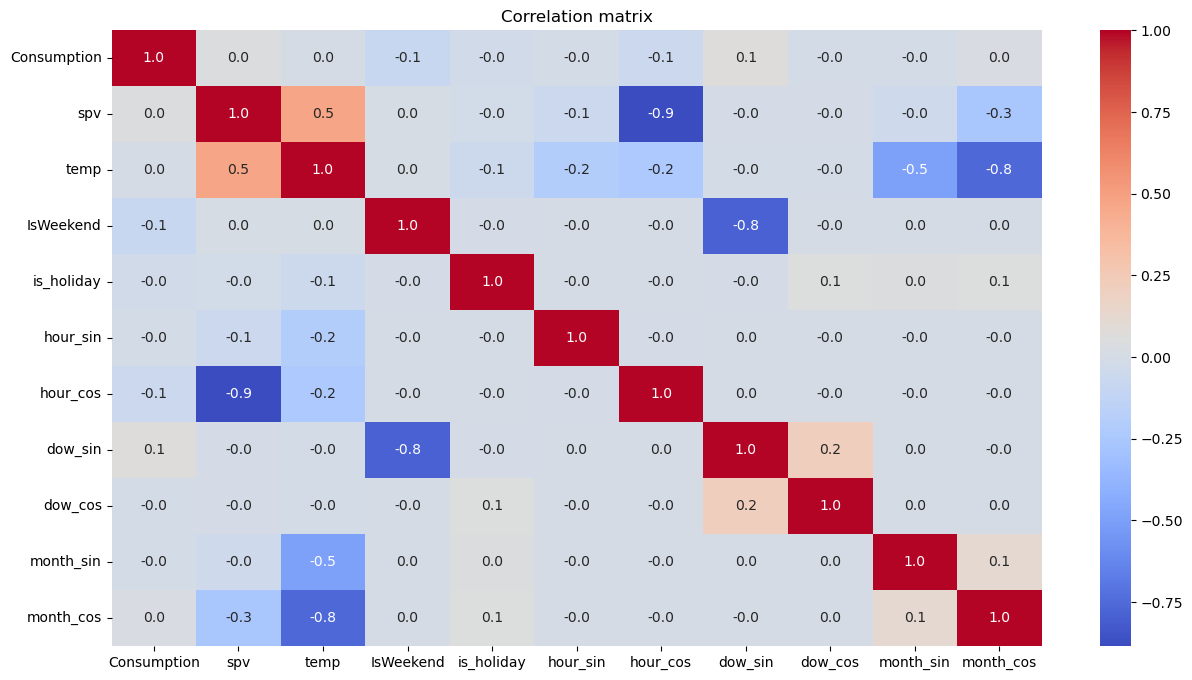

In [5]:
plt.figure(figsize=(15, 8))
corr = consumers_it_df.corr(numeric_only=True, method="spearman")
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

100%|██████████| 1696/1696 [00:02<00:00, 729.10it/s] 


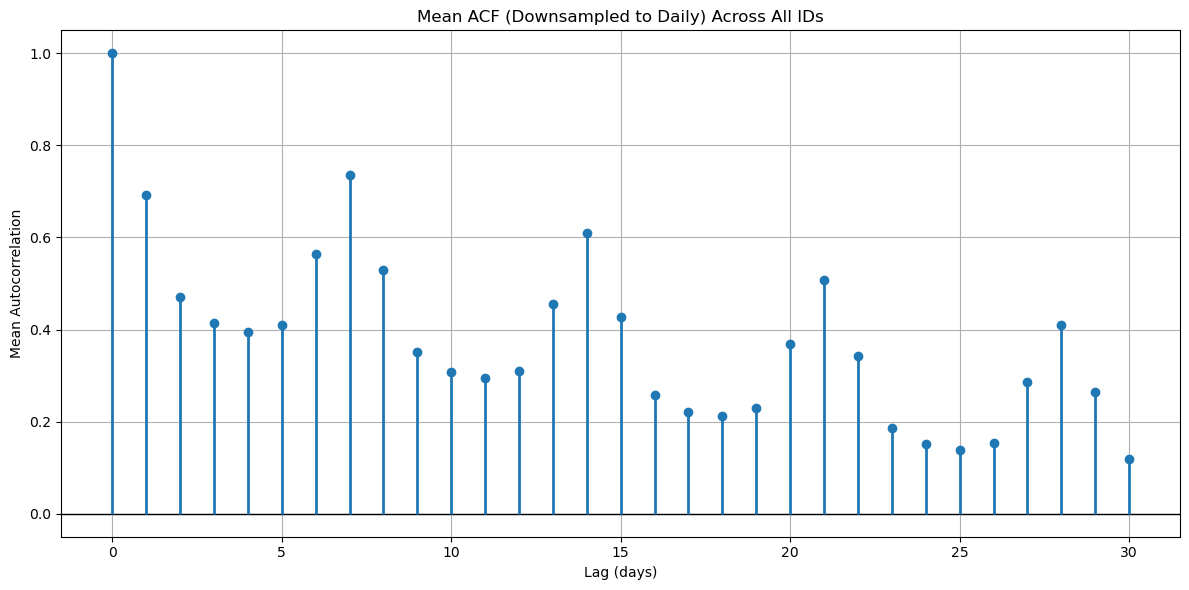

In [6]:
# Parameters
daily_lags = list(range(0, 31))  # 1 to 30 days (lagged every 24 hours)
acf_dict = {}

for id_val, group in tqdm(consumers_it_df.groupby("id")):
    ts = group["Consumption"].sort_index().dropna()

    # Subsample: keep 1 value every 24 hours
    ts_24h = ts.resample("24h").mean().dropna()

    # Skip constant or too-short series
    if ts_24h.var() <= 1e-8 or len(ts_24h) <= max(daily_lags):
        continue

    # Compute ACF
    acf_values = acf(ts_24h, nlags=max(daily_lags))
    acf_dict[id_val] = acf_values

# Convert to DataFrame
acf_df = pd.DataFrame(acf_dict).T
acf_df.columns = [f"lag_{i}" for i in range(acf_df.shape[1])]

# Extract only daily lags
selected_cols = [f"lag_{i}" for i in daily_lags]
mean_acf = acf_df[selected_cols].mean(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.axhline(0, color="black", linewidth=1)
plt.vlines(x=daily_lags, ymin=0, ymax=mean_acf.values, linewidth=2)
plt.plot(daily_lags, mean_acf.values, "o")
plt.xlabel("Lag (days)")
plt.ylabel("Mean Autocorrelation")
plt.title("Mean ACF (Downsampled to Daily) Across All IDs")
plt.grid(True)
plt.tight_layout()
plt.show()

100%|██████████| 1696/1696 [00:04<00:00, 382.55it/s]


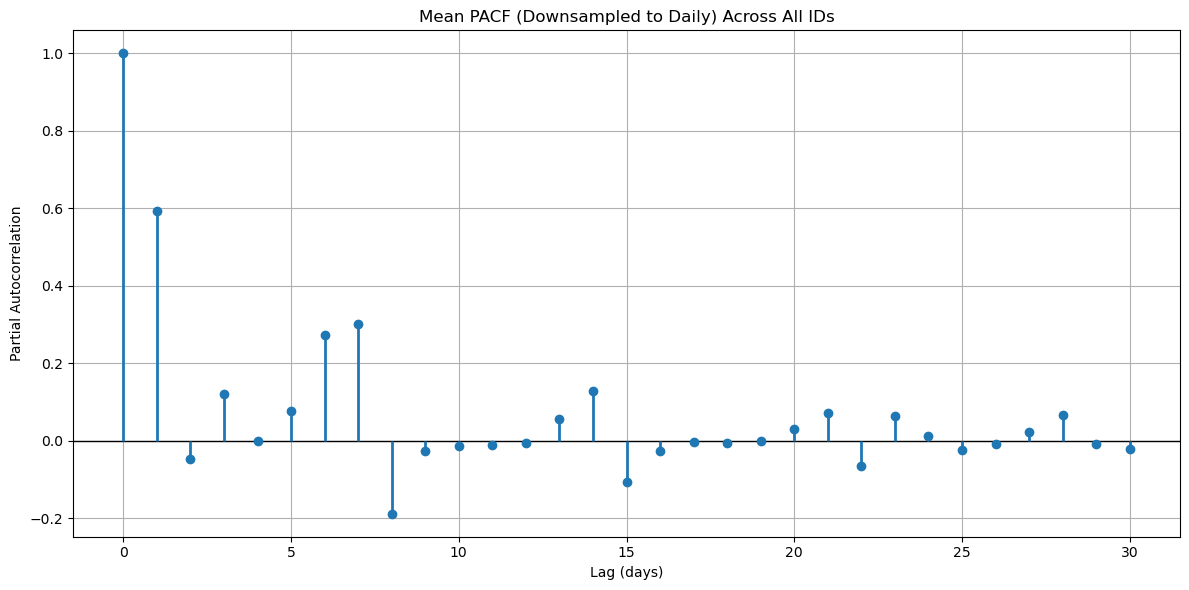

In [7]:
# Parameters
daily_lags = list(range(0, 31))  # 1 to 30 days (lagged every 24 hours)
pacf_dict = {}

for id_val, group in tqdm(consumers_it_df.groupby("id")):
    ts = group["Consumption"].sort_index().dropna()
    ts = ts[ts.index <= "2024-08-01"]

    # Subsample: keep 1 value every 24 hours
    ts_24h = ts.resample("24h").mean().dropna()

    # Skip constant or too-short series
    if ts_24h.var() <= 1e-8 or len(ts_24h) <= 2 * max(daily_lags):
        continue

    # Compute PACF
    pacf_values = pacf(ts_24h, nlags=max(daily_lags))
    pacf_dict[id_val] = pacf_values

# Convert to DataFrame
pacf_df = pd.DataFrame(pacf_dict).T
pacf_df.columns = [f"lag_{i}" for i in range(pacf_df.shape[1])]

# Extract only daily lags
selected_cols = [f"lag_{i}" for i in daily_lags]
mean_pacf = pacf_df[selected_cols].mean(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.axhline(0, color="black", linewidth=1)
plt.vlines(x=daily_lags, ymin=0, ymax=mean_pacf.values, linewidth=2)
plt.plot(daily_lags, mean_pacf.values, "o")
plt.xlabel("Lag (days)")
plt.ylabel("Partial Autocorrelation")
plt.title("Mean PACF (Downsampled to Daily) Across All IDs")
plt.grid(True)
plt.tight_layout()
plt.show()

### Spain

In [8]:
print("Number of datapoints in each consumer")
consumers_es_df.groupby("id").size().describe()

Number of datapoints in each consumer


count       98.000000
mean     21679.489796
std       4690.952455
min       5855.000000
25%      23373.000000
50%      23373.000000
75%      23373.000000
max      23373.000000
dtype: float64

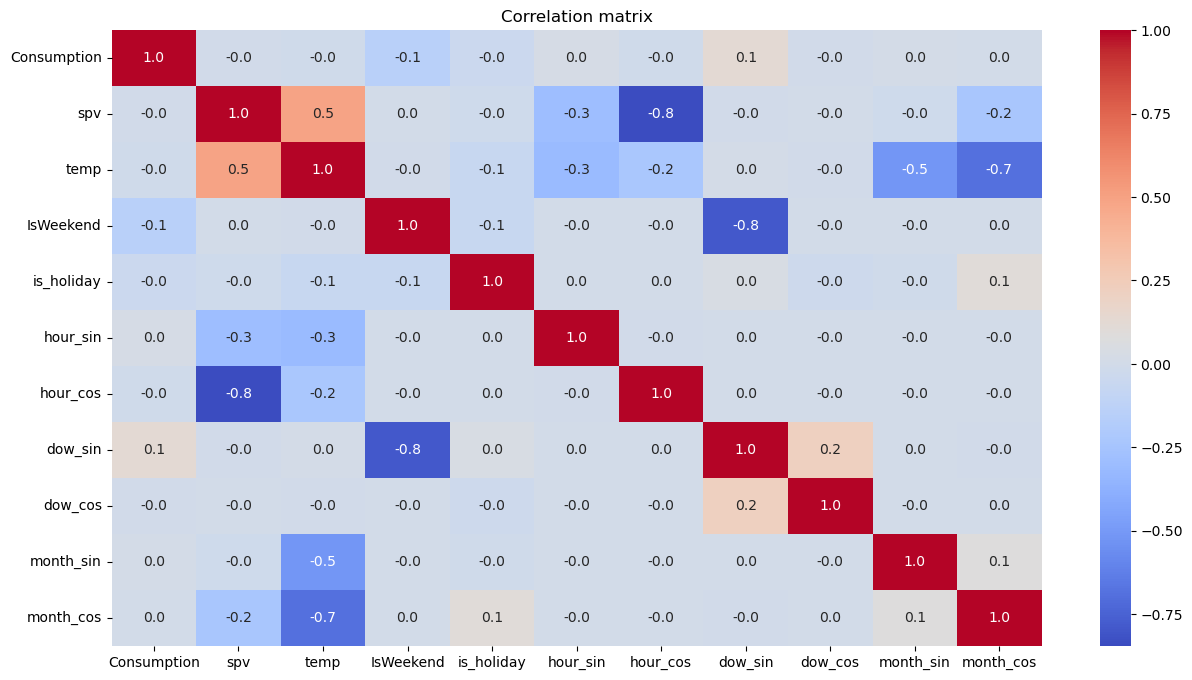

In [9]:
plt.figure(figsize=(15, 8))
corr = consumers_es_df.corr(numeric_only=True, method="spearman")
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

100%|██████████| 98/98 [00:00<00:00, 421.97it/s]


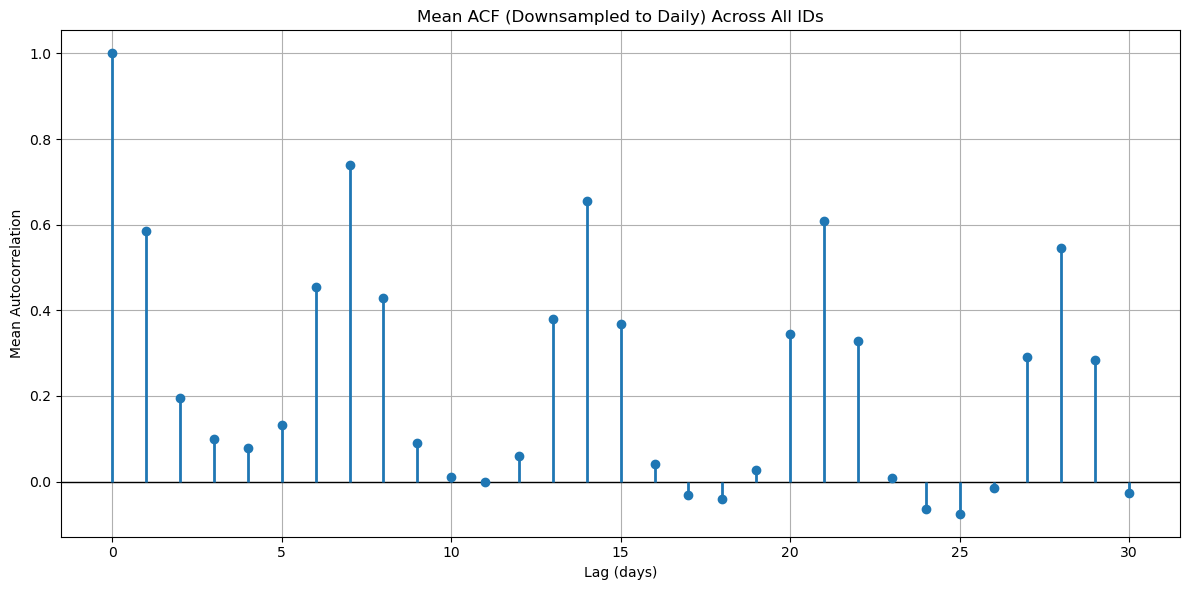

In [10]:
# Parameters
daily_lags = list(range(0, 31))  # 1 to 30 days (lagged every 24 hours)
acf_dict = {}

for id_val, group in tqdm(consumers_es_df.groupby("id")):
    ts = group["Consumption"].sort_index().dropna()

    # Subsample: keep 1 value every 24 hours
    ts_24h = ts.resample("24h").mean().dropna()

    # Skip constant or too-short series
    if ts_24h.var() <= 1e-8 or len(ts_24h) <= max(daily_lags):
        continue

    # Compute ACF
    acf_values = acf(ts_24h, nlags=max(daily_lags))
    acf_dict[id_val] = acf_values

# Convert to DataFrame
acf_df = pd.DataFrame(acf_dict).T
acf_df.columns = [f"lag_{i}" for i in range(acf_df.shape[1])]

# Extract only daily lags
selected_cols = [f"lag_{i}" for i in daily_lags]
mean_acf = acf_df[selected_cols].mean(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.axhline(0, color="black", linewidth=1)
plt.vlines(x=daily_lags, ymin=0, ymax=mean_acf.values, linewidth=2)
plt.plot(daily_lags, mean_acf.values, "o")
plt.xlabel("Lag (days)")
plt.ylabel("Mean Autocorrelation")
plt.title("Mean ACF (Downsampled to Daily) Across All IDs")
plt.grid(True)
plt.tight_layout()
plt.show()

100%|██████████| 98/98 [00:00<00:00, 361.62it/s]


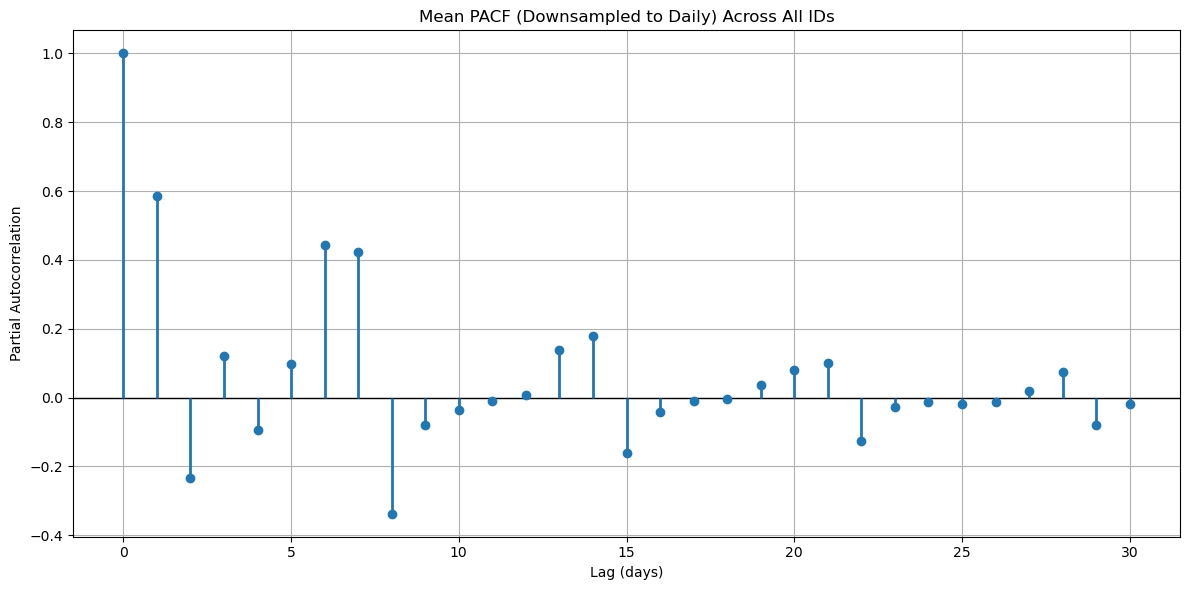

In [11]:
# Parameters
daily_lags = list(range(0, 31))  # 1 to 30 days (lagged every 24 hours)
pacf_dict = {}

for id_val, group in tqdm(consumers_es_df.groupby("id")):
    ts = group["Consumption"].sort_index().dropna()

    # Subsample: keep 1 value every 24 hours
    ts_24h = ts.resample("24h").mean().dropna()

    # Skip constant or too-short series
    if ts_24h.var() <= 1e-8 or len(ts_24h) <= 2 * max(daily_lags):
        continue

    # Compute PACF
    pacf_values = pacf(ts_24h, nlags=max(daily_lags))
    pacf_dict[id_val] = pacf_values

# Convert to DataFrame
pacf_df = pd.DataFrame(pacf_dict).T
pacf_df.columns = [f"lag_{i}" for i in range(pacf_df.shape[1])]

# Extract only daily lags
selected_cols = [f"lag_{i}" for i in daily_lags]
mean_pacf = pacf_df[selected_cols].mean(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.axhline(0, color="black", linewidth=1)
plt.vlines(x=daily_lags, ymin=0, ymax=mean_pacf.values, linewidth=2)
plt.plot(daily_lags, mean_pacf.values, "o")
plt.xlabel("Lag (days)")
plt.ylabel("Partial Autocorrelation")
plt.title("Mean PACF (Downsampled to Daily) Across All IDs")
plt.grid(True)
plt.tight_layout()
plt.show()

## Modeling

In [12]:
# ----------------------------------
# 1. Convert to long format
# ----------------------------------


def forecast(df, forecast_start, forecast_end):
    # ----------------------------------
    # 2. Define forecast window
    # ----------------------------------
    steps = (
        int(
            (
                pd.to_datetime(forecast_end) - pd.to_datetime(forecast_start)
            ).total_seconds()
            / 3600
        )
        + 1
    )

    # ----------------------------------
    # 3. Forecast per customer
    # ----------------------------------

    preds_res = []
    true_res = []
    skipped_customers = []

    for cust_id, g in tqdm(df.groupby("id"), desc="Forecasting per customer"):

        tmp_df = g.copy().asfreq("h").ffill()
        tmp_df = tmp_df.drop(columns=["id"])

        # Train-test split
        train_df = tmp_df[tmp_df.index < forecast_start]
        test_df = tmp_df[
            (tmp_df.index >= forecast_start) & (tmp_df.index <= forecast_end)
        ]

        available_hours = len(train_df)
        if available_hours < 720:
            print(f"Skipping customer {cust_id} due to insufficient data")
            skipped_customers.append(cust_id)
            continue

        # Model setup
        forecaster = ForecasterRecursive(
            regressor=LGBMRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=8,
                num_leaves=40,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.5,
                reg_lambda=0.5,
                random_state=42,
                verbose=-1,
            ),
            lags=[24, 168, 2 * 168],
        )

        forecaster.fit(
            y=train_df["Consumption"], exog=train_df.drop(columns=["Consumption"])
        )

        # Forecast
        preds = forecaster.predict(
            steps=steps, exog=test_df.drop(columns=["Consumption"])
        )
        preds.index = pd.date_range(forecast_start, forecast_end, freq="h")

        # Store results
        preds_res.append(
            pd.DataFrame(
                {"timestamp": preds.index, "forecast": preds.values, "id": cust_id}
            )
        )
        true_res.append(
            pd.DataFrame(
                {
                    "timestamp": test_df.index,
                    "actual": test_df["Consumption"].values,
                    "id": cust_id,
                }
            )
        )

    # ----------------------------------
    # 4. Combine all forecasts
    # ----------------------------------

    # Step 4: Combine into wide-format DataFrames
    pred_df = pd.concat(preds_res, ignore_index=True)
    true_df = pd.concat(true_res, ignore_index=True)

    # Pivot to wide format: rows = timestamps, columns = customer IDs
    forecast_wide = pred_df.pivot(index="timestamp", columns="id", values="forecast")
    actual_wide = true_df.pivot(index="timestamp", columns="id", values="actual")

    return forecast_wide, actual_wide, skipped_customers

## July Testing

In [13]:
use_sample = True
if use_sample:
    # Sample 100 consumers
    consumers_it_df_july = consumers_it_df[
        consumers_it_df["id"].isin(consumers_it_df["id"].sample(100, random_state=42))
    ]
else:
    consumers_it_df_july = consumers_it_df.copy()
consumers_es_df_july = consumers_es_df.copy()

consumers_it_df_july = consumers_it_df_july[
    consumers_it_df_july.index < pd.to_datetime("2024-08-01")
]
# remove id with less than 2*720 datapoints
consumers_it_df_july = consumers_it_df_july[
    consumers_it_df_july["id"].map(consumers_it_df_july["id"].value_counts()) >= 2 * 744
]
consumers_es_df_july = consumers_es_df_july[
    consumers_es_df_july.index < pd.to_datetime("2024-08-01")
]
# remove id with less than 2*720 datapoints
consumers_es_df_july = consumers_es_df_july[
    consumers_es_df_july["id"].map(consumers_es_df_july["id"].value_counts()) >= 2 * 744
]

In [14]:
forecast_start = "2024-07-01"
forecast_end = "2024-07-31 23:00:00"
pred_it_july, true_it_july, _ = forecast(
    consumers_it_df_july, forecast_start, forecast_end
)
pred_es_july, true_es_july, _ = forecast(
    consumers_es_df_july, forecast_start, forecast_end
)

Forecasting per customer: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]


In [15]:
pred_it_july = pred_it_july.clip(lower=0)
pred_es_july = pred_es_july.clip(lower=0)

evaluate(
    pred_it=pred_it_july,
    true_it=true_it_july,
    pred_es=pred_es_july,
    true_es=true_es_july,
)


                 FORECAST EVALUATION REPORT                 

IT PERFORMANCE
------------------------------------------------------------

Metric                 Score  Weight  Weighted Score
Absolute Error   4581.157758     1.0     4581.157758
Portfolio Error  2065.983662    10.0    20659.836618

Top 3 consumers with highest error in Italy:

id
VALUEMWHMETERINGDATA_customerIT_2654    2084.76
VALUEMWHMETERINGDATA_customerIT_2423     409.64
VALUEMWHMETERINGDATA_customerIT_718      298.46

ES PERFORMANCE
------------------------------------------------------------

Metric                 Score  Weight  Weighted Score
Absolute Error   7761.937717     5.0    38809.688584
Portfolio Error  2179.561575    50.0   108978.078732

Top 3 consumers with highest error in Spain:

id
VALUEMWHMETERINGDATA_customerES_70     1177.82
VALUEMWHMETERINGDATA_customerES_114     711.13
VALUEMWHMETERINGDATA_customerES_266     494.82

------------------------------------------------------------
                 

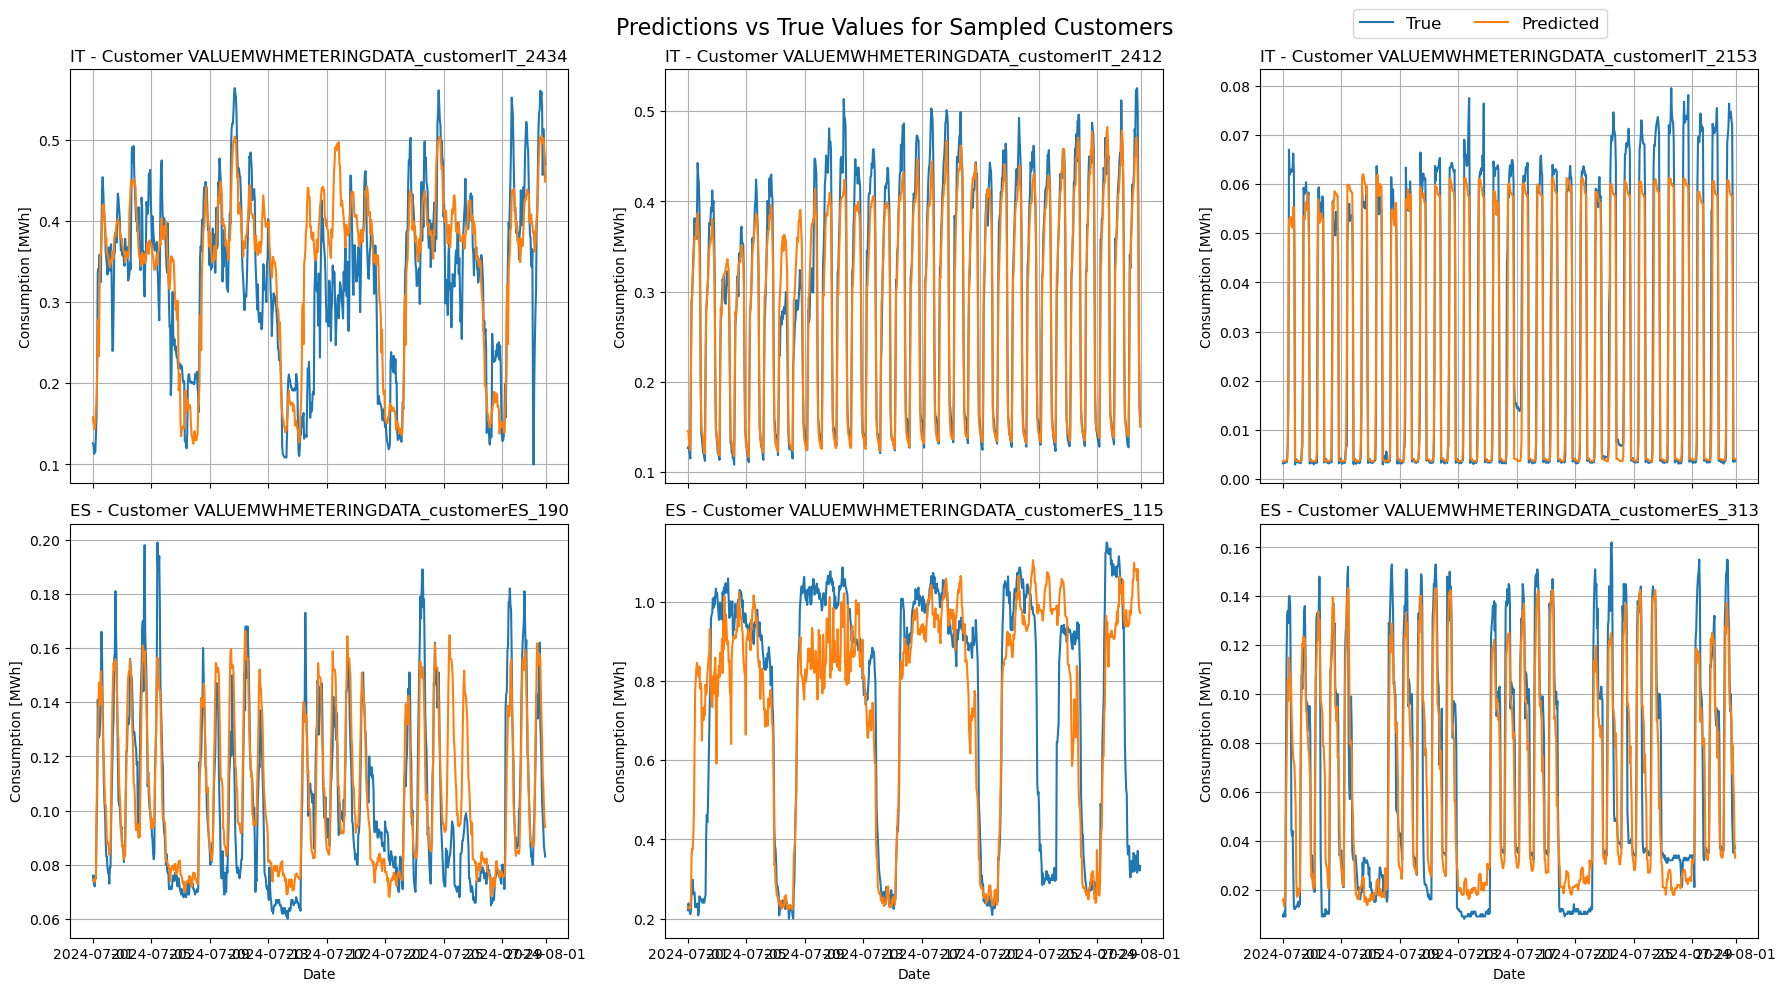

In [16]:
# Sample 3 random IDs from each country
sample_ids_it = (
    consumers_it_df_july["id"].drop_duplicates().sample(3, random_state=42).values
)
sample_ids_es = (
    consumers_es_df_july["id"].drop_duplicates().sample(3, random_state=42).values
)

fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# Top row: IT customers
for i, sample_id in enumerate(sample_ids_it):
    sample_preds = pred_it_july[sample_id]
    sample_true = true_it_july[sample_id]

    axs[0, i].plot(sample_true.index, sample_true.values, label="True")
    axs[0, i].plot(sample_preds.index, sample_preds.values, label="Predicted")
    axs[0, i].set_title(f"IT - Customer {sample_id}")
    axs[0, i].set_ylabel("Consumption [MWh]")
    axs[0, i].grid(True)

# Bottom row: ES customers
for i, sample_id in enumerate(sample_ids_es):
    sample_preds = pred_es_july[sample_id]
    sample_true = true_es_july[sample_id]

    axs[1, i].plot(sample_true.index, sample_true.values, label="True")
    axs[1, i].plot(sample_preds.index, sample_preds.values, label="Predicted")
    axs[1, i].set_title(f"ES - Customer {sample_id}")
    axs[1, i].set_xlabel("Date")
    axs[1, i].set_ylabel("Consumption [MWh]")
    axs[1, i].grid(axis="y")

# Common legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower right",
    ncol=2,
    bbox_to_anchor=(0.9, 0.95),
    fontsize="large",
)
fig.suptitle("Predictions vs True Values for Sampled Customers", fontsize=16)
plt.tight_layout()
plt.show()

## August Forecasting

In [ ]:
forecast_start = "2024-08-01"
forecast_end = "2024-08-31 23:00:00"
pred_it, true_it, skipped_it = forecast(consumers_it_df, forecast_start, forecast_end)
pred_es, true_es, skipped_es = forecast(consumers_es_df, forecast_start, forecast_end)

Forecasting per customer:  11%|█         | 187/1696 [01:20<08:33,  2.94it/s]

In [ ]:
pred_it.to_csv("predictions/pred_it.csv")
pred_es.to_csv("predictions/pred_es.csv")

#### Low data forecasting (Only Italy)


In [ ]:
consumers_it_df_skipped = consumers_it_df[consumers_it_df["id"].isin(skipped_it)]
for cust_id in consumers_it_df_skipped["id"].unique():
    pred_it[cust_id] = 0

consumers_es_df_skipped = consumers_es_df[consumers_es_df["id"].isin(skipped_es)]
for cust_id in consumers_es_df_skipped["id"].unique():
    pred_es[cust_id] = 0

pred_it = pred_it.clip(lower=0)
pred_es = pred_es.clip(lower=0)

In [ ]:
pred_it